In [2]:
import keras
from keras.datasets import mnist
from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

from functools import partial

from collections import defaultdict

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import tensorflow as tf

import shap


In [3]:
#Load MNIST data

dataset_name = "mnist_3_vs_5"

img_rows, img_cols = 28, 28

num_classes = 10
batch_size = 32

included_classes = { 3, 5 }

(x_train, y_train), (x_test, y_test) = mnist.load_data()

keep_index_train = []
for i in range(y_train.shape[0]) :
    if y_train[i] in included_classes :
        keep_index_train.append(i)

keep_index_test = []
for i in range(y_test.shape[0]) :
    if y_test[i] in included_classes :
        keep_index_test.append(i)

x_train = x_train[keep_index_train]
x_test = x_test[keep_index_test]
y_train = y_train[keep_index_train]
y_test = y_test[keep_index_test]

n_train = int((x_train.shape[0] // batch_size) * batch_size)
n_test = int((x_test.shape[0] // batch_size) * batch_size)
x_train = x_train[:n_train]
x_test = x_test[:n_test]
y_train = y_train[:n_train]
y_test = y_test[:n_test]


x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print("x_train.shape = " + str(x_train.shape))

print("n train samples = " + str(x_train.shape[0]))
print("n test samples = " + str(x_test.shape[0]))

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#Binarize images

def _binarize_images(x, val_thresh=0.5) :
    
    x_bin = np.zeros(x.shape)
    x_bin[x >= val_thresh] = 1.
    
    return x_bin

x_train = _binarize_images(x_train, val_thresh=0.5)
x_test = _binarize_images(x_test, val_thresh=0.5)


x_train.shape = (11552, 28, 28, 1)
n train samples = 11552
n test samples = 1888


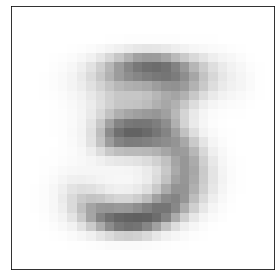

In [4]:
#Visualize background image distribution

pseudo_count = 1.0

x_mean = (np.sum(x_train, axis=(0, 3)) + pseudo_count) / (x_train.shape[0] + pseudo_count)
x_mean_logits = np.log(x_mean / (1. - x_mean))

f = plt.figure(figsize=(4, 4))

plot_ix = 0

plt.imshow(x_mean, cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

plt.xticks([], [])
plt.yticks([], [])

plt.tight_layout()
plt.show()


In [5]:
#Select background set of images

background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]


In [8]:
#Build predictor model and load weights

'''
predictor = Sequential()

predictor.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, name='conv2d_1'))
predictor.add(Conv2D(64, (3, 3), activation='relu', name='conv2d_2'))
predictor.add(MaxPooling2D(pool_size=(2, 2)))
predictor.add(Dropout(0.25))
predictor.add(Flatten())
predictor.add(Dense(128, activation='relu', name='dense_1'))
predictor.add(Dropout(0.5))
predictor.add(Dense(num_classes, activation='softmax', name='dense_2'))

predictor.load_weights('saved_models/mnist_binarized_cnn_10_digits.h5')
predictor.trainable = False

predictor.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adadelta(),
    metrics=['accuracy']
)
'''


In [6]:
#Directly load predictor model

predictor = load_model("saved_models/mnist_binarized_cnn_10_digits.h5")
predictor.trainable = False

predictor.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adadelta(),
    metrics=['accuracy']
)


In [7]:
#Execute DeepSHAP attribution method

e = shap.DeepExplainer(predictor, background)
#e = shap.DeepExplainer((predictor.layers[0].input, predictor.layers[-1].output), background)

shap_values = e.shap_values(x_test)


keras is no longer supported, please use tf.keras instead.


In [9]:
shap_values[0].shape

(1888, 28, 28, 1)

In [10]:

digit_test = np.argmax(y_test, axis=1)

importance_scores_test = np.zeros(shap_values[0].shape)

importance_scores_test[digit_test == 3, :, :, :] = shap_values[3][digit_test == 3, :, :, :]
importance_scores_test[digit_test == 5, :, :, :] = shap_values[5][digit_test == 5, :, :, :]

importance_scores_test = np.abs(importance_scores_test)


Test image 0:


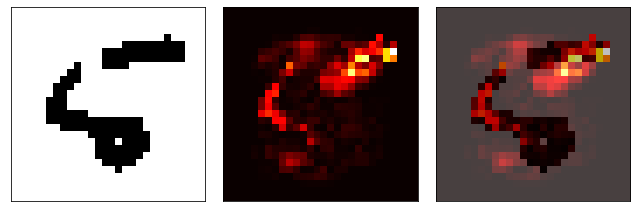

Test image 1:


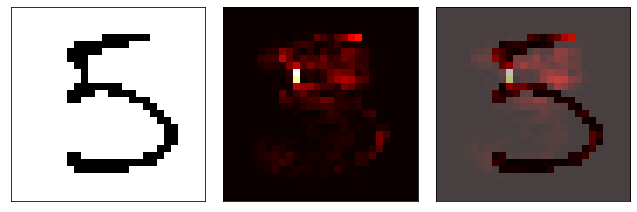

Test image 2:


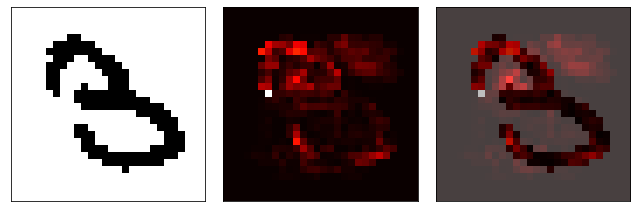

Test image 3:


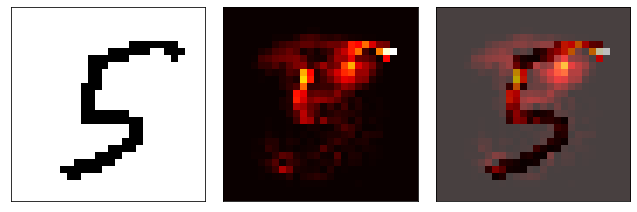

Test image 4:


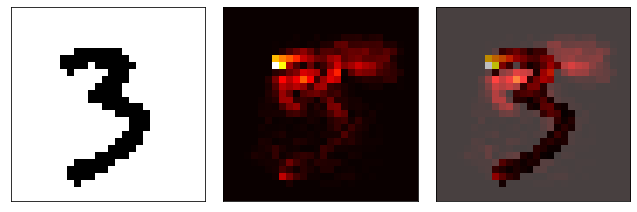

Test image 5:


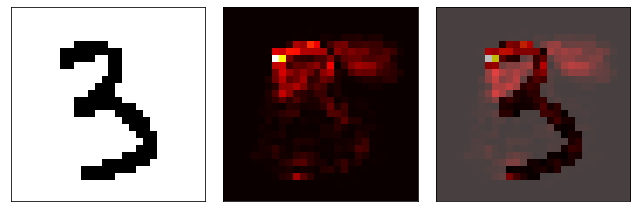

Test image 6:


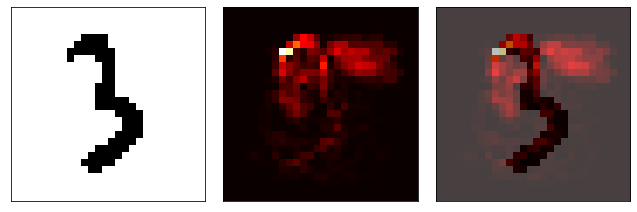

Test image 7:


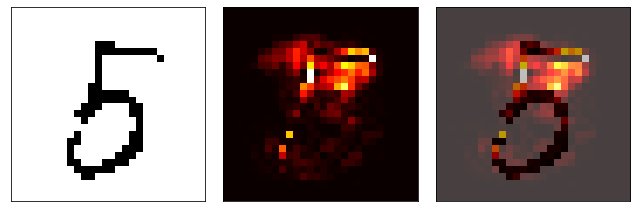

Test image 8:


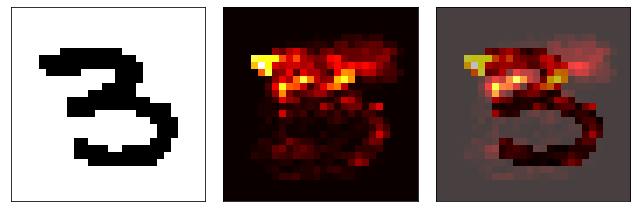

Test image 9:


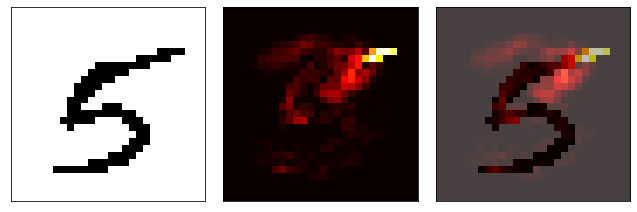

Test image 10:


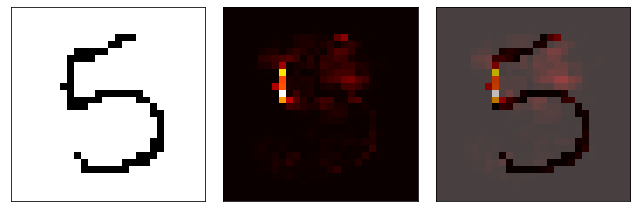

Test image 11:


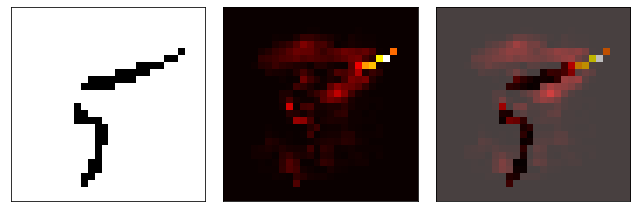

Test image 12:


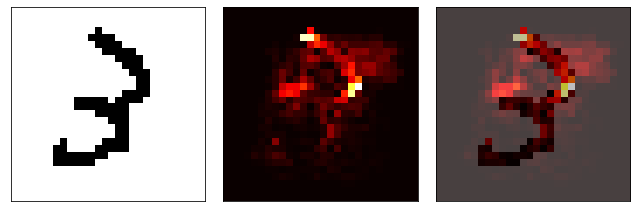

Test image 13:


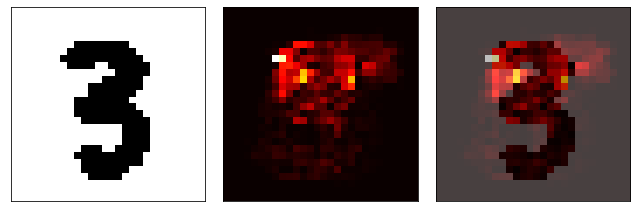

Test image 14:


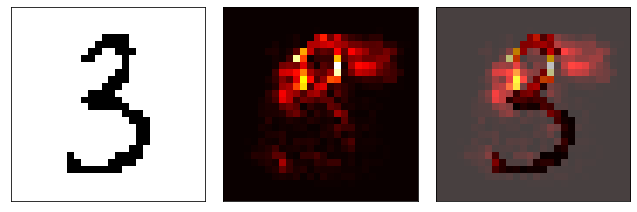

Test image 15:


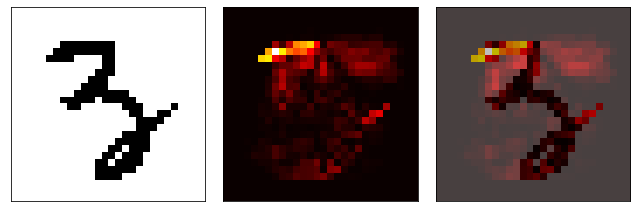

Test image 16:


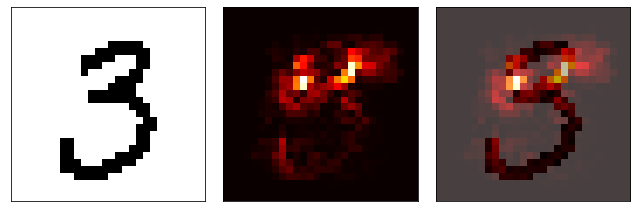

Test image 17:


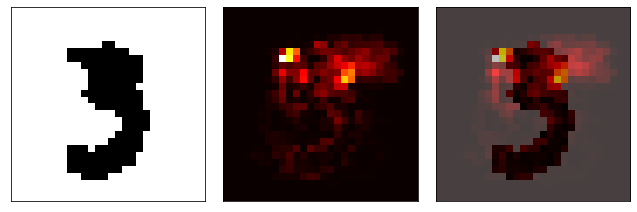

Test image 18:


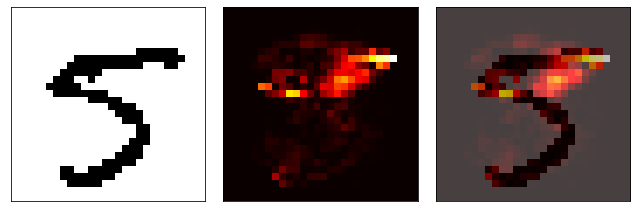

Test image 19:


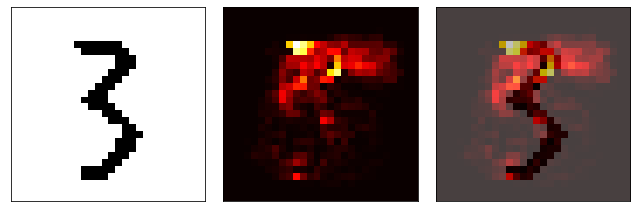

In [11]:
#Visualize a few images

for plot_i in range(0, 20) :
    
    print("Test image " + str(plot_i) + ":")
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3 * 3, 3))

    ax1.imshow(x_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax1)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax2.imshow(importance_scores_test[plot_i, :, :, 0], cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[plot_i, :, :, 0]), aspect='equal')

    plt.sca(ax2)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax3.imshow(x_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    ax3.imshow(importance_scores_test[plot_i, :, :, 0], alpha=0.75, cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[plot_i, :, :, 0]), aspect='equal')

    plt.sca(ax3)
    plt.xticks([], [])
    plt.yticks([], [])

    plt.tight_layout()
    plt.show()


In [12]:
#Save predicted importance scores

model_name = "deepshap_" + dataset_name

np.save(model_name + "_importance_scores_test", importance_scores_test)
